# Actual model connectivity 
## biophysical connvergence

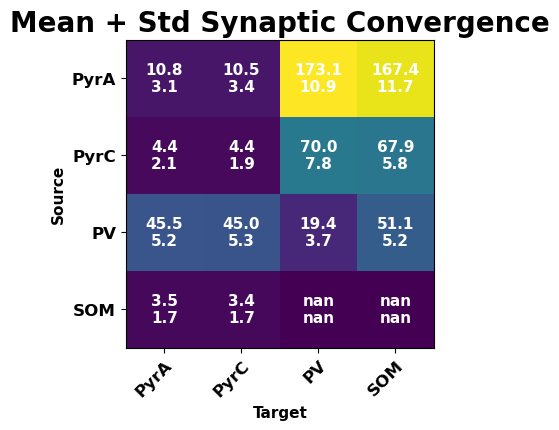

In [6]:
from bmtool import bmplot as bp

bp.convergence_connection_matrix(config="../Network-Parameters/circuit_config_homogenous.json",sources='BLA',targets='BLA',sids='pop_name',tids='pop_name',no_prepend_pop=True)

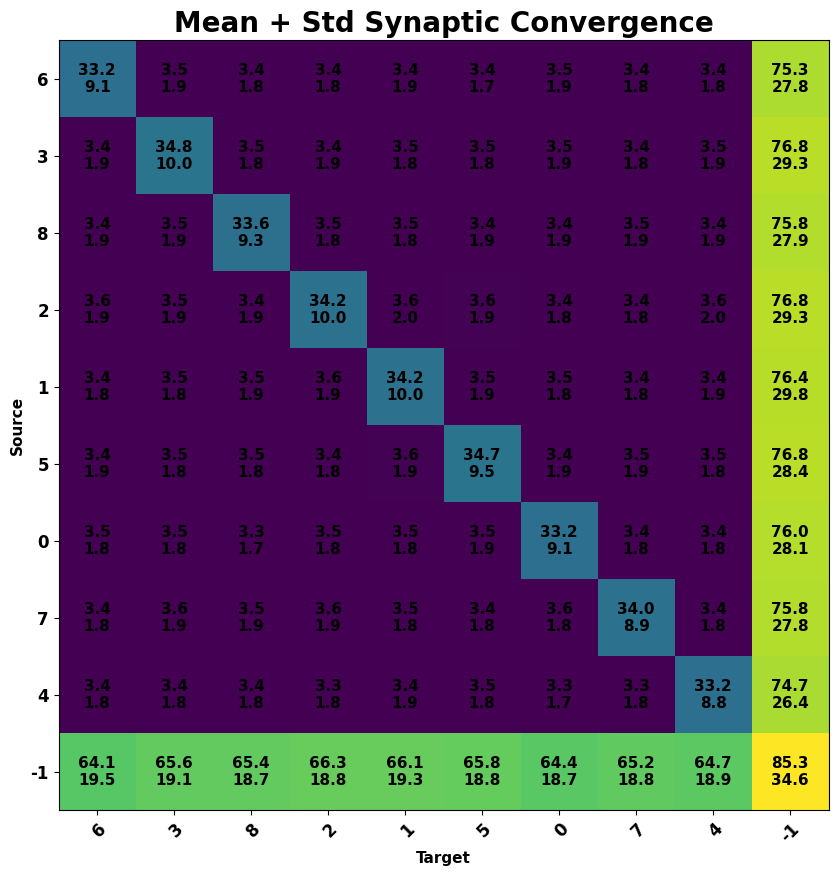

In [3]:
bp.convergence_connection_matrix(config="../Network-Parameters/simulation_config_baseline.json",sources='cortex',targets='cortex',sids='assembly_id',tids='assembly_id',no_prepend_pop=True)

## Shell convergence 

In [5]:
bp.convergence_connection_matrix(config="../Network-Parameters/circuit_config_homogenous.json",sources='shell',targets='cortex',sids='pop_name',tids='pop_name',no_prepend_pop=True)

/home/group/bmtool/bmtool/bmplot.py:554: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im1 = ax1.imshow(num)
/home/group/bmtool/bmtool/bmplot.py:554: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im1 = ax1.imshow(num)
/home/kac2cf/miniconda3/envs/neural-modeling/lib/python3.8/site-packages/matplotlib/axes/_base.py:1918: RuntimeWarning: invalid value encountered in scalar divide
  fig_aspect = bb.height / bb.width
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
/home/kac2cf/miniconda3/envs/neural-modeling/lib/python3.8/site-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/home/k

## Distance depended percent connectivity 
### This is a measure of on average out of the total number of cells an indivual cell could connect to within its distance rule

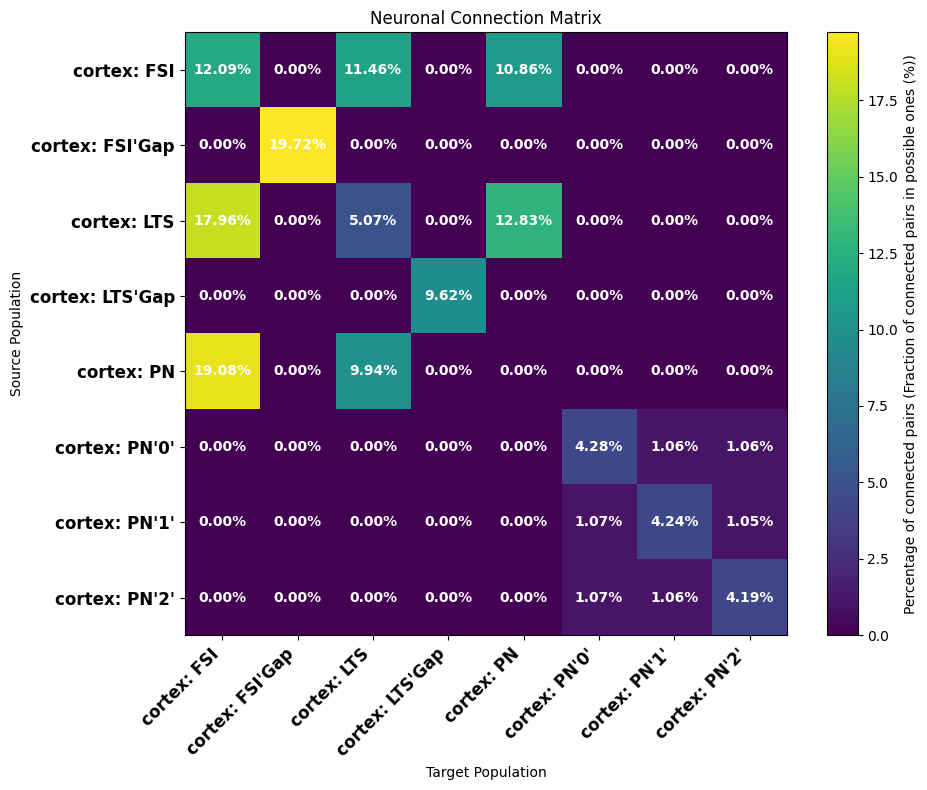

In [7]:
from bmtool import bmplot
bmplot.connector_percent_matrix(csv_path='../Network-Parameters/connection_report.csv',exclude_shell_connections=True)

In [ ]:
from bmtool import bmplot as bp
#bp.probability_connection_matrix(config="../../Network-Parameters/config_baseline.json",sources='cortex',targets='cortex',sids='pop_name',tids='pop_name',no_prepend_pop=True,line_plot=True)

In [1]:
from bmtool import graphs
import networkx as nx

Graph = graphs.generate_graph(config="../../Network-Parameters/config_baseline.json",source='cortex',target='cortex')

In [2]:
import networkx as nx
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist

def create_test_graph(num_nodes=500, distance_threshold=100, Pmax=1.0, sigma=20.0):
    """Create a test graph with nodes connected based on a Gaussian distance-dependent probability."""
    G = nx.DiGraph()
    np.random.seed(42)  # For reproducibility
    
    # Generate random positions for the nodes
    positions = np.random.rand(num_nodes, 3) * 100  # Positions in a 100x100x100 space
    labels = np.random.choice(['A', 'B'], size=num_nodes)  # Randomly assign population labels 'A' or 'B'
    
    # Add nodes to the graph
    for i in range(num_nodes):
        G.add_node(i, pos=positions[i], label=labels[i])
    
    # Add edges based on the distance-dependent probability
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                distance = np.linalg.norm(positions[i] - positions[j])
                if distance <= distance_threshold:
                    probability = Pmax * np.exp(-(distance**2) / (2 * sigma**2))
                    if np.random.rand() < probability:
                        G.add_edge(i, j)
    
    return G, positions

def gaussian_decay(distance, Pmax, sigma):
    """Gaussian decay function."""
    return Pmax * np.exp(-(distance**2) / (2 * sigma**2))

def estimate_parameters(G, distance_threshold=100):
    """Estimate Pmax and sigma for each population pair in the graph."""
    node_positions = nx.get_node_attributes(G, 'pos')
    node_labels = nx.get_node_attributes(G, 'label')
    nodes = list(node_positions.keys())
    positions = np.array([node_positions[node] for node in nodes])
    labels = [node_labels[node] for node in nodes]
    
    distances_dict = {}
    probabilities_dict = {}
    
    # Collect distances and probabilities for each population pair
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if i != j:
                distance = np.linalg.norm(positions[i] - positions[j])
                if distance <= distance_threshold:
                    source_label = labels[i]
                    target_label = labels[j]
                    population_pair = (source_label, target_label)
                    
                    if population_pair not in distances_dict:
                        distances_dict[population_pair] = []
                        probabilities_dict[population_pair] = []
                    
                    distances_dict[population_pair].append(distance)
                    probabilities_dict[population_pair].append(1 if G.has_edge(i, j) else 0)
    
    # Estimate parameters for each population pair
    estimates = {}
    for population_pair in distances_dict.keys():
        distances = np.array(distances_dict[population_pair])
        probabilities = np.array(probabilities_dict[population_pair])
        
        popt, _ = curve_fit(gaussian_decay, distances, probabilities, p0=[0.5, 100.0])
        Pmax_est, sigma_est = popt
        
        estimates[population_pair] = (Pmax_est, sigma_est)
    
    return estimates

# Create an example graph
num_nodes = 200
distance_threshold = 400
Pmax = 0.5
sigma = 200.0

G, positions = create_test_graph(num_nodes=num_nodes, distance_threshold=distance_threshold, Pmax=Pmax, sigma=sigma)

# Estimate Pmax and sigma for each population pair
estimates = estimate_parameters(Graph, distance_threshold=distance_threshold)
print(estimates)


{('PN', 'PN'): (0.07819621002901213, 99.44975696128638), ('PN', 'FSI'): (0.7273734067995593, 118.95855780666578), ('PN', 'LTS'): (0.3617656686764082, 119.30813609863452), ('FSI', 'PN'): (0.5916824426256566, 95.97194846674513), ('FSI', 'FSI'): (0.4908687839569687, 119.61563403971121), ('FSI', 'LTS'): (0.3630134781803959, 124.62475654117371), ('LTS', 'PN'): (0.9180791856978898, 98.0436109699204), ('LTS', 'FSI'): (0.5622727665528198, 124.77982841258202), ('LTS', 'LTS'): (0.5262475143336854, 93.31777553476478)}


This did an ok job at estimating Pmax and sigma. The values are fairly close to what is defined in the build_network. There are most like issues like with edge effect neurons but overall i think the build network distro is ~mostly fitted in the actually model with some degree of error but whatever.

In [2]:
from bmtool.util.util import load_nodes_from_config,load_nodes_from_paths

#nodes = load_nodes_from_paths([{'nodes_file': '/home/gjgpb9/L2-3-Model/Network-Parameters/network_rotated/cortex_nodes.h5', 'node_types_file': '/home/gjgpb9/L2-3-Model/Network-Parameters/network_rotated/cortex_node_types.csv'}])
nodes = load_nodes_from_config("../Network-Parameters/config_baseline.json")

In [4]:
nodes['cortex']

,node_type_id,model_type,model_template,pop_name,morphology,pos_x,pos_y,pos_z,rotation_angle_xaxis,rotation_angle_yaxis,rotation_angle_zaxis
node_id,,,,,,,,,,,
0,100,biophysical,hoc:CP_Cell,PN,blank.swc,204.561437,55.781565,96.544312,0.0,1.531130,1.459470
1,100,biophysical,hoc:CP_Cell,PN,blank.swc,-192.090770,265.664103,-62.992757,0.0,1.183618,1.191713
2,100,biophysical,hoc:CP_Cell,PN,blank.swc,-24.524847,-164.618108,1.999565,0.0,1.306221,1.190775
3,100,biophysical,hoc:CP_Cell,PN,blank.swc,267.163374,-286.979229,-65.277127,0.0,1.155872,1.123580
4,100,biophysical,hoc:CP_Cell,PN,blank.swc,-234.415651,-148.465761,-47.284553,0.0,1.234159,1.126005
...,...,...,...,...,...,...,...,...,...,...,...
9995,102,biophysical,hoc:LTS_Cell,LTS,blank.swc,246.302714,22.095008,-44.284092,0.0,0.332898,0.373644
9996,102,biophysical,hoc:LTS_Cell,LTS,blank.swc,57.752117,24.098235,114.685873,0.0,1.241381,3.510785
9997,102,biophysical,hoc:LTS_Cell,LTS,blank.swc,254.315172,-153.847806,-19.902274,0.0,0.068764,3.984983


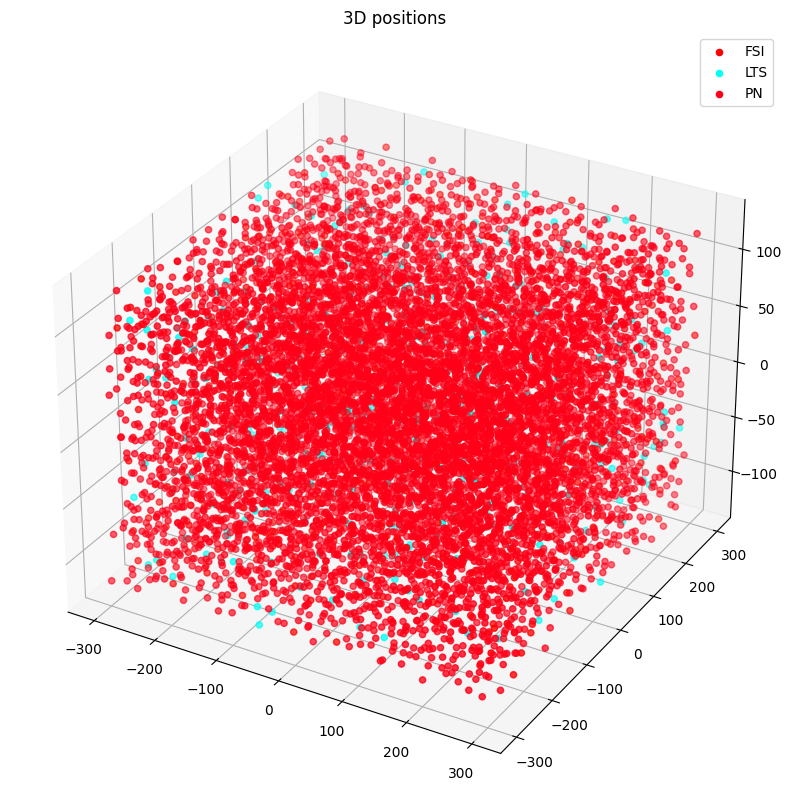

In [1]:
from bmtool import bmplot as bp
bp.plot_3d_positions(config="../Network-Parameters/config_baseline.json",populations_list='cortex',group_by='pop_name')

,node_type_id,model_type,model_template,pop_name,morphology,pos_x,pos_y,pos_z,rotation_angle_xaxis,rotation_angle_yaxis,rotation_angle_zaxis
node_id,,,,,,,,,,,
8700,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,-229.623869,258.049222,-119.651375,0.0,2.962410,2.293033
8701,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,194.440630,-236.254833,-28.374638,0.0,4.674000,4.616000
8702,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,-279.058018,90.460009,-74.105640,0.0,1.173492,4.657174
8703,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,66.735643,-87.195927,-25.445203,0.0,2.447247,3.902217
8704,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,-210.705068,-263.948482,-43.084572,0.0,5.784014,3.689190
...,...,...,...,...,...,...,...,...,...,...,...
9595,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,155.877601,268.376515,-88.235259,0.0,2.585879,3.597178
9596,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,55.730094,10.449233,-111.659098,0.0,0.620678,5.022221
9597,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,47.043234,244.416309,24.658470,0.0,5.870475,1.839334


,node_type_id,model_type,model_template,pop_name,morphology,pos_x,pos_y,pos_z,rotation_angle_xaxis,rotation_angle_yaxis,rotation_angle_zaxis
node_id,,,,,,,,,,,
8700,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,-229.623869,258.049222,-119.651375,0.0,2.962410,2.293033
8701,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,194.440630,-236.254833,-28.374638,0.0,4.674000,4.616000
8702,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,-279.058018,90.460009,-74.105640,0.0,1.173492,4.657174
8703,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,66.735643,-87.195927,-25.445203,0.0,2.447247,3.902217
8704,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,-210.705068,-263.948482,-43.084572,0.0,5.784014,3.689190
8705,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,-151.603225,241.631542,-51.585263,0.0,3.258017,2.623102
8706,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,15.404983,-21.025130,-26.875375,0.0,5.672801,3.890203
8707,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,178.243174,205.176272,-72.962260,0.0,2.985453,2.234992
8708,101,biophysical,hoc:FSI_Cell,FSI,blank.swc,90.285810,-0.677233,114.762642,0.0,0.650534,1.961111


,node_type_id,model_type,model_template,pop_name,morphology,pos_x,pos_y,pos_z,rotation_angle_xaxis,rotation_angle_yaxis,rotation_angle_zaxis
node_id,,,,,,,,,,,
9600,102,biophysical,hoc:LTS_Cell,LTS,blank.swc,-235.420100,-63.068178,-83.143215,0.0,4.007461,5.698393
9601,102,biophysical,hoc:LTS_Cell,LTS,blank.swc,231.330285,181.305779,-10.635334,0.0,0.709339,0.124387
9602,102,biophysical,hoc:LTS_Cell,LTS,blank.swc,-146.242221,74.057237,6.803230,0.0,5.135960,5.119189
9603,102,biophysical,hoc:LTS_Cell,LTS,blank.swc,-84.062579,-206.272535,9.382878,0.0,3.750040,5.162937
9604,102,biophysical,hoc:LTS_Cell,LTS,blank.swc,136.631404,-208.376037,52.068535,0.0,0.810251,4.569885
...,...,...,...,...,...,...,...,...,...,...,...
9995,102,biophysical,hoc:LTS_Cell,LTS,blank.swc,246.302714,22.095008,-44.284092,0.0,0.332898,0.373644
9996,102,biophysical,hoc:LTS_Cell,LTS,blank.swc,57.752117,24.098235,114.685873,0.0,1.241381,3.510785
9997,102,biophysical,hoc:LTS_Cell,LTS,blank.swc,254.315172,-153.847806,-19.902274,0.0,0.068764,3.984983


,node_type_id,model_type,model_template,pop_name,morphology,pos_x,pos_y,pos_z,rotation_angle_xaxis,rotation_angle_yaxis,rotation_angle_zaxis
node_id,,,,,,,,,,,
0,100,biophysical,hoc:CP_Cell,PN,blank.swc,204.561437,55.781565,96.544312,0.0,1.531130,1.459470
1,100,biophysical,hoc:CP_Cell,PN,blank.swc,-192.090770,265.664103,-62.992757,0.0,1.183618,1.191713
2,100,biophysical,hoc:CP_Cell,PN,blank.swc,-24.524847,-164.618108,1.999565,0.0,1.306221,1.190775
3,100,biophysical,hoc:CP_Cell,PN,blank.swc,267.163374,-286.979229,-65.277127,0.0,1.155872,1.123580
4,100,biophysical,hoc:CP_Cell,PN,blank.swc,-234.415651,-148.465761,-47.284553,0.0,1.234159,1.126005
...,...,...,...,...,...,...,...,...,...,...,...
8695,100,biophysical,hoc:CP_Cell,PN,blank.swc,203.175536,214.286523,-57.789268,0.0,1.255814,1.438590
8696,100,biophysical,hoc:CP_Cell,PN,blank.swc,-213.763457,-199.438424,-16.159356,0.0,1.489638,1.525355
8697,100,biophysical,hoc:CP_Cell,PN,blank.swc,6.175630,-141.458336,-115.609494,0.0,1.303302,1.156841


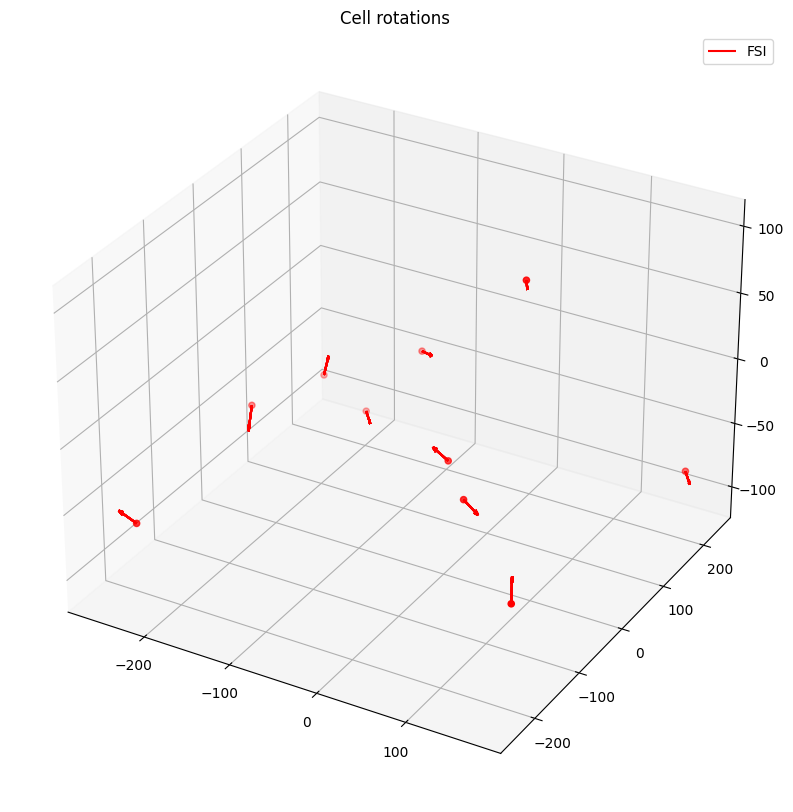

In [1]:
from bmtool import bmplot as bp
bp.cell_rotation_3d(config="../Network-Parameters/config_baseline.json",populations_list='cortex',group_by='pop_name',save_file=False,quiver_length=20,arrow_length_ratio=0.25,max_cells=10)